# Hack.Diversity Tech.Dive Project -- Diamond Price Predictions
### Team: FAMS-Tech
#### Team Members and their Contributions 
Ana Veloz Parks: Dashboard

Angelie Heredia Frías: Exploratory Data Analysis, Streamlit App, Operations Lead

Francheska Diaz: Machine Learning Model

Michael Hernandez: Preliminary Research on Machine Learning Models

Stanley Jean-Jacques: Data Cleaning

-------------------------------------------------------------

## Exploratory Data Analysis

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np

# Libraries for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)

# Libraries for regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import metrics

# Library for model pickle
import pickle

##### Data Overview

In [3]:
# Loading the datafile to inspect the first 5 entries
# Each row of the dataset is a diamond 
df = pd.read_csv("wholesale_diamonds.csv")

print("Number of rows: %i"%len(df))
print('Shape of the dataset: ', df.shape) # Printing total number of rows and columns
df.head()

Number of rows: 407280
Shape of the dataset:  (407280, 12)


,index,carat,cut,color,clarity,depth,table,cost (dollars),length (mm),width (mm),height (mm),year
0,0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,2010
1,1,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,2010
2,2,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,2010
3,3,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,2010
4,4,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,2010


To gain a better understanding of the data, we used a table of summary statistics (created using the describe function). The table of summary statistics provides insight into some of the (numerical) variables that need cleaning prior to building the data model. One thing to note about the data, 'carat' has a count of 405,232, making it the only (numerical) variable that doesn't have 407,280 entries and is, therefore, missing data. Next, note that the 'cost (dollars)' variable has a minimum of -998. Based on this information, there are potentially multiple negative cost values that should be dealt with as this is not an accurate representation of how prices work in the real-world. Lastly, the 'length (mm)', 'width (mm)', and 'height (mm)' variables all have minimums of 0. As it is impossible for an object to have zero dimension, these values can cause issues with our data model.

In [4]:
# Printing table of summary statistics
# Rounding to 2 decimals to limit decimal numbers
df.describe().round(2) 

,index,carat,depth,table,cost (dollars),length (mm),width (mm),height (mm),year
count,407280.00,405232.00,407280.00,407280.00,407280.00,407280.00,407280.00,407280.00,407280.00
mean,16969.50,0.80,61.75,57.46,4372.97,5.73,5.73,3.54,2015.50
std,9797.65,0.47,1.43,2.24,4503.62,1.12,1.11,0.71,3.45
min,0.00,0.20,43.00,43.00,-998.00,0.00,0.00,0.00,2010.00
25%,8484.75,0.40,61.00,56.00,1043.00,4.71,4.72,2.91,2012.75
50%,16969.50,0.70,61.80,57.00,2655.00,5.69,5.71,3.52,2015.50
75%,25454.25,1.04,62.50,59.00,5960.00,6.53,6.53,4.03,2018.25
max,33939.00,4.13,79.00,95.00,26930.00,10.14,10.10,31.80,2021.00


When deciding how to trim the data, one place to start is to check if there are any duplicate rows. Duplicates data can easily be deleted (using the drop_duplicates function) if necessary. In this case, the data does not appear to have any duplicate rows, as shown below.

In [5]:
# Looking for duplicate rows
df[df.duplicated()==True].count() # There are no duplicate rows

index             0
carat             0
cut               0
color             0
clarity           0
depth             0
table             0
cost (dollars)    0
length (mm)       0
width (mm)        0
height (mm)       0
year              0
dtype: int64

The table of summary statistics provides a count of all the continuous variables, but it is important to be aware of all variables with null values. The df.isnull().sum() function reveals that the only variable with missing values is the 'carat' variable. Note that 'carat' is missing 2,048 values; this is consistent with the count of 405,232 reported in the table of summary statistics above (given that there are 407,280 rows of data).

In [6]:
# Finding the null values by variable
print(df.isnull().sum())

index                0
carat             2048
cut                  0
color                0
clarity              0
depth                0
table                0
cost (dollars)       0
length (mm)          0
width (mm)           0
height (mm)          0
year                 0
dtype: int64


To begin the exploratory data analysis, understanding the variables' data types is necessary. This helps determine which visualizations and forms of analyses are appropriate for each variable.

In [7]:
# Examining the datatypes and non-null values for each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407280 entries, 0 to 407279
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           407280 non-null  int64  
 1   carat           405232 non-null  float64
 2   cut             407280 non-null  object 
 3   color           407280 non-null  object 
 4   clarity         407280 non-null  object 
 5   depth           407280 non-null  float64
 6   table           407280 non-null  float64
 7   cost (dollars)  407280 non-null  int64  
 8   length (mm)     407280 non-null  float64
 9   width (mm)      407280 non-null  float64
 10  height (mm)     407280 non-null  float64
 11  year            407280 non-null  int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 37.3+ MB


##### Data Distribution

In order to gain a broad glimpse into the categorical variables, we look at the count of the 'cut', 'color', and 'clarity' variables. Doing so helps us understand the distribution of each variable.

In [8]:
def count_function(variable):
    print('COUNT OF DIAMONS BY', variable.upper(), '\n')
    print(df[variable].value_counts(), '\n')
    return '-'*50

print(count_function('cut'))
print(count_function('color'))
print(count_function('clarity'))

COUNT OF DIAMONS BY CUT 

Ideal        162876
Premium      103680
Very Good     91740
Good          37056
Fair          11928
Name: cut, dtype: int64 

--------------------------------------------------
COUNT OF DIAMONS BY COLOR 

G    86064
E    73368
F    70848
H    63708
D    51324
I    40692
J    21276
Name: color, dtype: int64 

--------------------------------------------------
COUNT OF DIAMONS BY CLARITY 

SI1     98844
VS2     91980
SI2     70080
VS1     61260
VVS2    38040
VVS1    28320
IF      13224
I1       5532
Name: clarity, dtype: int64 

--------------------------------------------------


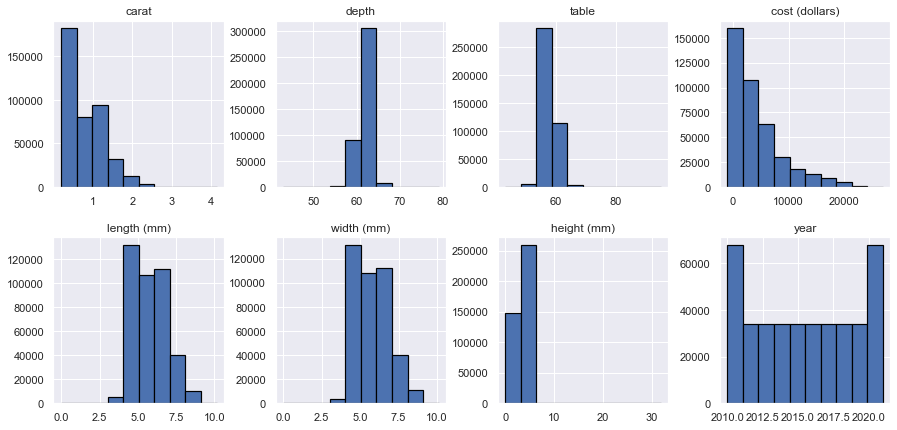

In [9]:
# Dropping the index column because it is not necessary to see its destribution
no_index_df = df.drop(columns=['index'])

# Plotting histograms of columns to get a general sense of the data
no_index_df.hist(edgecolor='black', linewidth=1.2, figsize=(15, 15), layout=(4,4))
plt.show()

##### Boxplots

The two boxplots below help visualize the outliers the numerical variables (with the exception of 'year') have. As the graphs show, all of these variables have outliers. When data modeling, outliers should be dealt with (either by trimming the data or replacing outliers with variable means or medians) to avoid overfitting the data in order to build an accurate model.

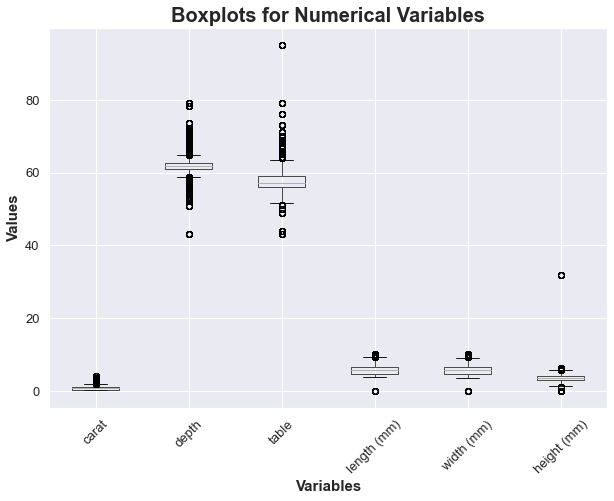

In [10]:
# Creating boxplots for all variables with dataypes of float64
df.loc[:,df.dtypes==np.float64].boxplot(grid=True, rot=45, fontsize=13, figsize=(10, 7))

# Adding title and axis names
plt.title('Boxplots for Numerical Variables', fontsize=20, fontweight='bold')
plt.xlabel('Variables', fontsize=15, fontweight='bold')
plt.ylabel('Values', fontsize=15, fontweight='bold')

# Displaying boxplot
plt.show()

The boxplot for 'cost (dollars)' shows that the negative cost values are not considered considered outliers. Therefore, we can concluded that there are numerous negative cost values that must be cleaned. A count of the negative values (shown below the boxplot) reveals that 'cost (dollars)' has 2,037 negative values. Cleaning these negative costs must come before cleaning the 'cost (dollars)' outliers because some outliers may no longer be considered outliers once the negative values are removed or replaced. Note that the boxplot for 'cost (dollars)' must be on a separate graph from the rest of the numerical variables because 'cost (dollars)' has considerable larger values than the rest of the variables, and thus it would not be practical for them to be graphed together.

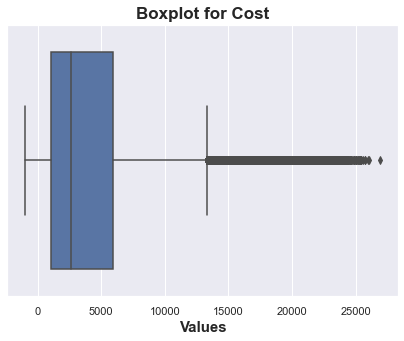

In [11]:
# Creating boxplot for 'cost (dollars)' variable
# This boxplot was not included in the previous graph because its values are a lot larger
plt.figure(figsize=(7,5))
sns.boxplot(x=df["cost (dollars)"])

# Adding title and axis names
plt.title('Boxplot for Cost', fontsize=17, fontweight='bold')
plt.xlabel('Values', fontsize=15, fontweight='bold')

# Displaying boxplot
plt.show()

In [12]:
# Getting a count of how many values in 'cost (dollars)' are negative
negative_cost = df['cost (dollars)'][df['cost (dollars)'] < 0].count()
print('Count of negative cost values:', negative_cost)

Count of negative cost values: 2037


##### Correlation

While all variables contribute to the cost of the diamonds, the heatmap below helps to show how some variables have a stronger influence than others. For instance, a diamond's dimensions (length, width, and height) have the strongest correlation with its cost. In addition, the carat and cost of the diamond are also strongly correlated. Though the depth, table, and year also influence diamonds' cost, the correlation between these three variables and cost is not as strong as the correlations between cost and dimensions or carats.

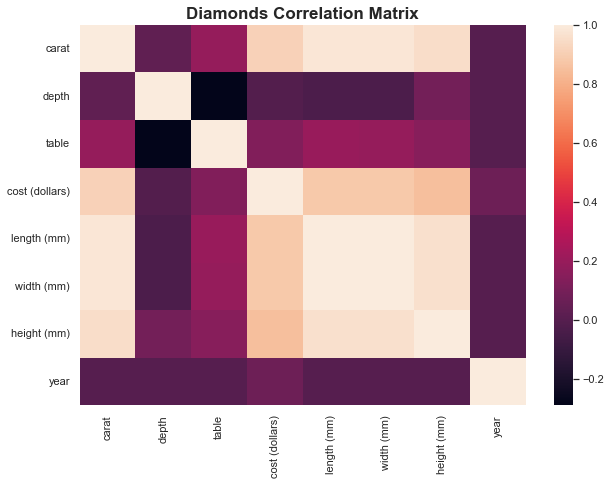

In [13]:
# Correlation matrix for model
# Using no_index_df because we do not need index for correlation
corr_matrix = no_index_df.corr().round(2)
plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot = False) 

# Adding title and displaying heatmap
plt.title('Diamonds Correlation Matrix', fontsize=17, fontweight='bold')
plt.show()

------------
## Data Cleaning

##### Removing Column

The 'index' column is not necessary for the data modeling and is therefore is removed. In addition, the index as is would not be useful because it will not be updated as rows of corrupted data are dropped (making it inaccurate).

In [14]:
# Making a deep copy of our dataframe
# This is the dataframe that will be cleaned
clean_df = df.copy()

In [15]:
# Dropping index column
clean_df.drop(['index'], inplace = True, axis = 1)

##### Removing Corrupt Rows of Data

There are 2,048 null values in the carat column that must be removed as they are considered corrupt. This will allow for better analysis of our dataset.

In [16]:
# Checking for null values in the original dataset
print("Count of null carat values *before* cleaning:", df['carat'].isnull().sum())

# Dropping nulls values
clean_df.dropna(inplace=True)
clean_df.isnull().sum()

# Checking for null values in the original dataset
print("Count of null carat values *after* cleaning:", clean_df['carat'].isnull().sum())

Count of null carat values *before* cleaning: 2048
Count of null carat values *after* cleaning: 0


There are negative cost values and dimensions with values of zero in the datasets. These data are also considered to be corrupt as it is impossible to have a negative cost and for the length, width, or height of an object to be zero.

In [17]:
# Count of dimensions with values of 0
print("Count of length with value of 0 *before* cleaning:", df['length (mm)'] [df['length (mm)'] <= 0].count())
print("Count of width with value of 0 *before* cleaning:", df['width (mm)'] [df['width (mm)'] <= 0].count())
print("Count of height with value of 0 *before* cleaning:", df['height (mm)'] [df['height (mm)'] <= 0].count())

# Count of 'cost (dollars)' with negative values
print("Count of negative cost values *before* cleaning:", df['cost (dollars)'] [df['cost (dollars)'] < 0].count())
print('\n', '-' * 50, '\n')


# Dropping negatives cost values and zero dimension values
dropped = clean_df[(clean_df['length (mm)'] <= 0) | (clean_df['height (mm)'] <= 0) | 
                   (clean_df['width (mm)'] <=0) | (clean_df['cost (dollars)'] < 0)].index
clean_df.drop(dropped, inplace= True)


# Count of dimensions with values of 0
print("Count of length with value of 0 *after* cleaning:", clean_df['length (mm)'] [clean_df['length (mm)'] <= 0].count())
print("Count of width with value of 0 *after* cleaning:", clean_df['width (mm)'] [clean_df['width (mm)'] <= 0].count())
print("Count of height with value of 0 *after* cleaning:", clean_df['height (mm)'] [clean_df['height (mm)'] <= 0].count())


# Count of 'cost (dollars)' with negative values
print("Count of negative cost values *after* cleaning:", clean_df['cost (dollars)'] [clean_df['cost (dollars)'] < 0].count())


Count of length with value of 0 *before* cleaning: 48
Count of width with value of 0 *before* cleaning: 36
Count of height with value of 0 *before* cleaning: 132
Count of negative cost values *before* cleaning: 2037

 -------------------------------------------------- 

Count of length with value of 0 *after* cleaning: 0
Count of width with value of 0 *after* cleaning: 0
Count of height with value of 0 *after* cleaning: 0
Count of negative cost values *after* cleaning: 0


##### Removing Outliers

Outliers, or values in the data that fall outside the overall pattern of normal distribution, often indicate the presence of corrupted data. In the case of machine learning, outliers must be dealt with because they can affect the accuracy of our models. One method used for detecting outliers is skewness; it is used to determine how data are distributed. Skewness value should fall between -1 and 1, and any major deviation from this range indicates the presence of extreme values. Below, we use the df.skew() function to find the skewness for all of our numerical variables. In doing so we are able to determine that the variables 'carat', 'cost (dollars)' and 'height (mm)' all have values that lie outside of the normal distribution. In other words, these three variables have the most concerning outliers.

In [18]:
# Identifying outliners with skewness
# Ideal skewness is between -1 and 1
print('-' * 50)
print('Skewness *before* cleaning the data')
print('Ideal skewness is between -1 and 1') 
print('-' * 50, '\n')
print(clean_df.skew(numeric_only=True))

--------------------------------------------------
Skewness *before* cleaning the data
Ideal skewness is between -1 and 1
-------------------------------------------------- 

carat             1.113906
depth            -0.067586
table             0.861265
cost (dollars)    1.653415
length (mm)       0.400164
width (mm)        0.394971
height (mm)       2.243572
year             -0.000135
dtype: float64


Once identifying which variables have a skew outside of the desired range, we chose quantile-based flooring and capping as our method for cleaning the data. With this method, outliers are capped at the value of the variables' 90th percentile and floored at the value of the variables' 10th percentile. In other words, all values above the 90th percentile are replaced the variables' 90th percentile. The same is done for variables below the 10th percentile.

In [19]:
# Using quantile-based Flooring and Capping to remove outliers
# In this method, we set a threshold consisting of the lower (10th percentile) 
# and higher (90th percentile) to replace outliers

# Carat
# Finding the 10th and 90th percentile values
print('Carat 10th percentile:', clean_df['carat'].quantile(0.10))
print('Carat 90th percentile:', clean_df['carat'].quantile(0.90), '\n')

# Carat
# Replacing outliers with the 10th and 90th percentile values
clean_df['carat'] = np.where (clean_df['carat'] < 0.31, 0.31, clean_df['carat'] )
clean_df['carat'] = np.where (clean_df['carat'] > 1.51, 1.51, clean_df['carat'] )



# Cost (dollars)
# Finding the 10th and 90th percentile values
print('Cost 10th percentile:', clean_df['cost (dollars)'].quantile(0.10)) # Finding the 10th percentile values
print('Cost 90th percentile:', clean_df['cost (dollars)'].quantile(0.90), '\n') # Finding the 90th percentile values

# Cost (dollars)
# Replacing outliers with the 10th and 90th percentile values
clean_df['cost (dollars)'] = np.where (clean_df['cost (dollars)'] < 710.0, 710.0, clean_df['cost (dollars)'] )
clean_df['cost (dollars)'] = np.where (clean_df['cost (dollars)'] > 11002.0, 11002.0, clean_df['cost (dollars)'] )



# Height
# Finding the 10th and 90th percentile values
print('Height 10th percentile:', clean_df['height (mm)'].quantile(0.10)) # Finding the 10th percentile values
print('Height 90th percentile:', clean_df['height (mm)'].quantile(0.90)) # Finding the 90th percentile values

# Height
# Replacing outliers with the 10th and 90th percentile values
clean_df['height (mm)'] = np.where (clean_df['height (mm)'] < 2.69, 2.69, clean_df['height (mm)'] )
clean_df['height (mm)'] = np.where (clean_df['height (mm)'] > 4.52, 4.52, clean_df['height (mm)'] )


Carat 10th percentile: 0.31
Carat 90th percentile: 1.51 

Cost 10th percentile: 710.0
Cost 90th percentile: 11002.0 

Height 10th percentile: 2.69
Height 90th percentile: 4.52


Once using the quantile-based flooring and capping, all of the variables now have a skew between -1 and 1.

In [20]:
# Identifying outliners with skewness
# Ideal skewness is between -1 and 1
print('-' * 50)
print('Skewness *after* cleaning the data')
print('Ideal skewness is between -1 and 1') 
print('-' * 50, '\n')
print(clean_df.skew(numeric_only=True))

--------------------------------------------------
Skewness *after* cleaning the data
Ideal skewness is between -1 and 1
-------------------------------------------------- 

carat             0.510777
depth            -0.067586
table             0.861265
cost (dollars)    0.916327
length (mm)       0.400164
width (mm)        0.394971
height (mm)       0.142981
year             -0.000135
dtype: float64


##### Overview of Cleaned Data

After cleaning the dataset, we have dropped one column and removed a total of 4,216 rows of data. The dataset now contains 403,064 rows and 11 columns. Below, the describe function shows how cleaning the datset has impacted the table of summary statistics. We now have no null values (all of the count values are the same), no negative cost values, and no dimensions with minimum values of zero. Note how the statistics for the 'carat', 'cost (dollars)', and 'height (mm)' were most affected. This change is to be expected as these were the three variables with concerning skewness whose outliers were replaced with 10th or 90th percentile values.

In [21]:
# Inspeacting the first 5 entries of the cleaned dataset
print('Shape of the cleaned dataset: ', clean_df.shape) # Printing total number of rows and columns
clean_df.head()

Shape of the cleaned dataset:  (403064, 11)


,carat,cut,color,clarity,depth,table,cost (dollars),length (mm),width (mm),height (mm),year
0,0.31,Ideal,E,SI2,61.5,55.0,710.0,3.95,3.98,2.69,2010
1,0.31,Good,E,VS1,56.9,65.0,710.0,4.05,4.07,2.69,2010
2,0.31,Premium,I,VS2,62.4,58.0,710.0,4.20,4.23,2.69,2010
3,0.31,Good,J,SI2,63.3,58.0,710.0,4.34,4.35,2.75,2010
4,0.31,Very Good,J,VVS2,62.8,57.0,710.0,3.94,3.96,2.69,2010


In [22]:
# Printing table of summary statistics for cleaned dataset
# Rounding to 2 decimal to limit decimals
clean_df.describe().round(2) 

,carat,depth,table,cost (dollars),length (mm),width (mm),height (mm),year
count,403064.00,403064.00,403064.00,403064.00,403064.00,403064.00,403064.00,403064.00
mean,0.77,61.75,57.46,3988.73,5.73,5.73,3.52,2015.50
std,0.40,1.43,2.24,3429.39,1.12,1.11,0.63,3.45
min,0.31,43.00,43.00,710.00,3.73,3.68,2.69,2010.00
25%,0.40,61.00,56.00,1053.00,4.71,4.72,2.91,2013.00
50%,0.70,61.80,57.00,2676.00,5.69,5.71,3.52,2016.00
75%,1.04,62.50,59.00,5982.00,6.53,6.53,4.03,2019.00
max,1.51,79.00,95.00,11002.00,10.14,10.10,4.52,2021.00


Below is a dashboard built with our newly cleaned data. This dashboard helps to provide an overview of what our final data looks like. Though the dashboard is meant to be interactive, due to Power BI public access issues, we can only provide an image at this time. Please see the GitHub link https://github.com/AngelieFrias/Diamonds-Price-Prediction to download the pbix document if you wish to.

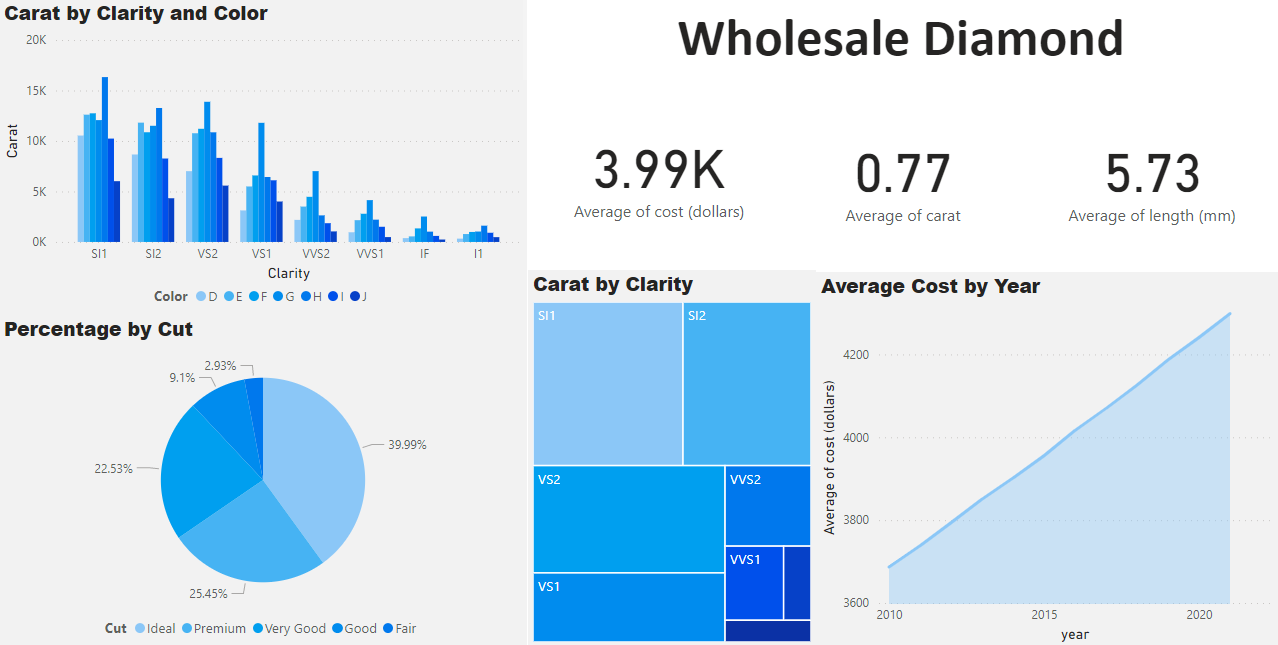

In [23]:
# Saving the cleaned dataset to a CSV
clean_df.to_csv('wholesale_diamond_cleaned.csv', index = False)

------------
## Data Modeling

We now have to convert categorical data values to numerical data values. We use one-hot encoding to convert categorical data into a binary vector using the get_dummies function. With one-hot encoding, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. All the values are zero, and the index is marked with a 1.

In [24]:
# One-hot encoding 
cut = pd.get_dummies(clean_df.cut, prefix="", columns=['cut'], drop_first = False)
del clean_df["cut"]
color = pd.get_dummies(clean_df.color, prefix="", columns=['color'], drop_first = False)
del clean_df["color"]
clarity = pd.get_dummies(clean_df.clarity, prefix="", columns=['clarity'], drop_first = False)
del clean_df["clarity"]

# Adding new columns from one-hot encoding to clean_df
clean_df= pd.concat([clean_df, cut, color, clarity], axis=1)

We need to split the dataset into train and test sets to evaluate how well our machine learning model performs. The train set is used to fit the model and the test set is used to test our model's prediction. We will split our dataset into input (X) and output (y). The size of the split is set to 0.20, where 20 percent of the dataset will be allocated to the test set and 80 percent will be allocated to the training set.

In [25]:
# Defining cost (dollars) as output (y) 
y = clean_df["cost (dollars)"]

# Deleting cost (dollars) from the dataset
del clean_df["cost (dollars)"]

# Defining all other features as input (x)
X = clean_df

# Splitting the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

We chose Random Forest Regression as our machine learning model because it provides higher accuracy through cross validation. n_estimators=100 is the number of trees we want to build before taking the maximum voting or averages of predictions. The higher the number of trees, the better the model's performance because they make predictions stronger and more stable.  

In [26]:
# Building random forest regression model
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# Fitting the model to X_train and y_train
regressor.fit(X_train, y_train)

# Making predictions
y_pred = regressor.predict(X_test)

###### Reggresion Evaluation Metrics

Mean Absolute Error (MAE): measures the absolute average distance between the real data and the predicted data.
Mean Square Error (MSE): measures the squared average distance between the real data and the predicted data.
Root Mean Squared Error (RMSE): measures how much error there is between the real data and the predicted data.
R^2 Value: measures how close the data are to the fitted regression line.

In [27]:
# Evaluating random forest regression model
print ('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred))
print ('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print ('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))   
print ('R^2 Value:', r2_score(y_test, y_pred))

Mean Absolute Error: 139.2341108943199
Mean Squared Error: 57104.23499715787
Root Mean Squared Error: 238.96492419842264
R^2 Value: 0.9951316517228981


The scatter plot displays the actual values along the X-axis, and displays the predicted values along the Y-axis.

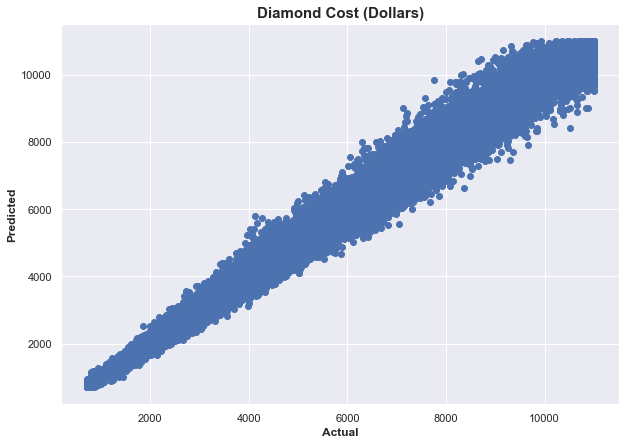

In [32]:
# Creating scatter plot
plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.title('Diamond Cost (Dollars)', fontsize=15, fontweight='bold')
plt.xlabel('Actual', fontsize=12, fontweight='bold')
plt.ylabel('Predicted', fontsize=12, fontweight='bold')
plt.show()

##### Saving Model to use in App

In [35]:
# Saving the Model so it can be used in Streamlit App
pickle_out = open('regressor.pkl', 'wb') 
pickle.dump(regressor, pickle_out) 
pickle_out.close()

------------
## Using the Data Model

Please note that due to the fact that Streamlit Apps can only be deployed through GitHub (and some bugs with Stremlit), we are unable to deploy the functioning app. The pickled file does not read with Streamlit. Use the following link to see how the Streamlit app works (without deployment): https://drive.google.com/file/d/1iW1buUoFDCUJXVclrLlN4WfFUh_HZgUd/view?usp=sharing. Please note that the video may be low quality due to Streamlit's screen-recording function.

You can view the app using the following link (but please note that the 'prediction' functions do not work because of reasons listed above): https://share.streamlit.io/angeliefrias/diamonds-price-prediction/main/Diamonds_RandomForest.py